# Himmelblau minimization with PyGMO
Copyright (c) 2010-2022, Delft University of Technology. All rights reserved. This file is part of the Tudat. Redistribution  and use in source and binary forms, with or without modification, are permitted exclusively under the terms of the Modified BSD license. You should have received a copy of the license with this file. If not, please or visit: http://tudat.tudelft.nl/LICENSE.

## Context
This aim of this tutorial is to illustrate the functionalities of PyGMO through the minimization problem of an analytical
function (Himmelblau function).

Please note that thi example is thus not related to TudatPy.

It is assumed that the reader of this tutorial is already familiar with the content of [this basic PyGMO tutorial](https://docs.tudat.space/en/latest/_src_advanced_topics/optimization_pygmo.html#about-pygmo).

The full PyGMO documentation is available [on this website](https://esa.github.io/pygmo2/index.html). Be careful to read the
correct the documentation webpage (there is also a similar one for previous yet now outdated versions [here](https://esa.github.io/pygmo/index.html); as you can see, they can easily be confused).

PyGMO is the Python counterpart of [PAGMO](https://esa.github.io/pagmo2/index.html).

## Import statements
The required import statements are made here, at the very beginning.

Some standard modules are first loaded. These are `math`, `numpy` and `matplotlib`.

Then, the `pygmo` library that will be used is imported.

In [1]:
# Load standard modules
import math
import pygmo
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import ticker as mtick
import numpy as np
from numpy import random

# Load pygmo library
import pygmo as pg

## Create user-defined problem
A PyGMO-compatible problem class is now defined. This is known in PyGMO terminology as a User-Defined Problem (UDP).
This class, `HimmelblauOptimization`, will be taken as input from the `pygmo.problem()` class to create the actual PyGMO
problem.

To be PyGMO-compatible, the UDP class must have two methods:

- `get_bounds()`: it takes no input and returns a tuple of two n-dimensional lists, containing respectively the lower and upper boundaries of each variable. The dimension of the problem (i.e. the value of n) is automatically inferred by the return type of the this function.
- `fitness(x)`: it takes a np.array as input (of size n) and returns a list with p values as output. In case of single-objective optimization, p = 1, otherwise p will be equal to the number of objectives.
 
Please refer to [PyGMO UDP tutorial](https://esa.github.io/pygmo2/tutorials/coding_udp_simple.html) for more on how to define a UDP.

In [2]:
class HimmelblauOptimization:

    def __init__(self,
                 x_min: float,
                 x_max: float,
                 y_min: float,
                 y_max: float):
        
        # Set input arguments as attributes, representing the problem bounds for both design variables
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max

    def get_bounds(self):
        return ([self.x_min, self.y_min], [self.x_max, self.y_max])

    def fitness(self, x):
        # Compute Himmelblau function value
        function_value = math.pow(x[0] * x[0] + x[1] - 11.0, 2.0) + math.pow(x[0] + x[1] * x[1] - 7.0, 2.0)
        
        # Return list
        return [function_value]

## Create problem
With the custom problem class defined, we can now setup the optimisation.
We do so by instantiating `HimmelblauOptimization` with bounds for both the x and y design variables as [-5, 5].
The PyGMO problem is then created using the `pygmo.problem()` method. Note that an instance of the UDP class must be passed as input to pygmo.problem() and NOT the class itself. It is also possible to use a PyGMO UDP, i.e. a problem that is already defined in PyGMO, but it will not be shown in this tutorial.
See also [this tutorial](https://esa.github.io/pygmo2/tutorials/using_problem.html) on using PyGMO problems.

In [3]:
# Instantiation of the UDP problem
udp = HimmelblauOptimization(-5.0, 5.0, -5.0, 5.0)

# Creation of the pygmo problem object
prob = pygmo.problem(udp)

# Print the problem's information
print(prob)

Problem name: <class '__main__.HimmelblauOptimization'>
	C++ class name: pybind11::object

	Global dimension:			2
	Integer dimension:			0
	Fitness dimension:			1
	Number of objectives:			1
	Equality constraints dimension:		0
	Inequality constraints dimension:	0
	Lower bounds: [-5, -5]
	Upper bounds: [5, 5]
	Has batch fitness evaluation: false

	Has gradient: false
	User implemented gradient sparsity: false
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0

	Thread safety: none



## Create algorithm
As a second step, we have to create an algorithm to solve the problem. Many different algorithms are available through PyGMO, including heuristic methods and local optimizers.

In this example, we will use the Differential Evolution (DE). Similarly to the UDP, it is also possible to create a User-Defined Algorithm (UDA), but in this tutorial we will use an algorithm readily available in PyGMO. [This webpage](https://esa.github.io/pygmo2/overview.html#list-of-algorithms) offers a list of all of the PyGMO optimisation algorithms that are available.

See also [this tutorial](https://esa.github.io/pygmo2/tutorials/using_algorithm.html) on PyGMO algorithms.

In [4]:
# Define number of generations
number_of_generations = 1

# Fix seed
current_seed = 171015

# Create Differential Evolution object by passing the number of generations as input
de_algo = pygmo.de(gen=number_of_generations, seed=current_seed)

# Create pygmo algorithm object
algo = pygmo.algorithm(de_algo)

# Print the algorithm's information
print(algo)

Algorithm name: DE: Differential Evolution [stochastic]
	C++ class name: pagmo::de

	Thread safety: basic

Extra info:
	Generations: 1
	Parameter F: 0.800000
	Parameter CR: 0.900000
	Variant: 2
	Stopping xtol: 0.000001
	Stopping ftol: 0.000001
	Verbosity: 0
	Seed: 171015


## Initialise population
A population in PyGMO is essentially a container for multiple individuals. Each individual has an associated decision vector which can change (evolution), the resulting fitness vector, and an unique ID to allow their tracking. The population is initialized starting from a specific problem to ensure that all individuals are compatible with the UDP. The default population size is 0.

In [5]:
# Set population size
pop_size = 1000

# Create population
pop = pygmo.population(prob, size=pop_size, seed=current_seed)

# Inspect population (this is going to be long, uncomment if desired)
inspect_pop = False
if inspect_pop:
    print(pop)

## Evolve population
We now want to make this population evolve, as to (hopefully) get closer to optimum solutions.

In a loop, we thus call `algo.evolve(pop)` 100 times to make the population evolve 100 times. During each generation, we also save the list of fitness and of decision variables.

After 100 generations, and 201,000 function evaluations, we can see that we find the optimum of (3, 2) with a deviation in the order of $10^{-6}$.

In [6]:
# Set number of evolutions
number_of_evolutions = 100

# Initialize empty containers
individuals_list = []
fitness_list = []

# Evolve population multiple times
for i in range(number_of_evolutions):
    pop = algo.evolve(pop)
    individuals_list.append(pop.get_x()[pop.best_idx()])
    fitness_list.append(pop.get_f()[pop.best_idx()])

# Extract the best individual
print('\n########### PRINTING CHAMPION INDIVIDUALS ###########\n')
print('Fitness (= function) value: ', pop.champion_f)
print('Decision variable vector: ', pop.champion_x)
print('Number of function evaluations: ', pop.problem.get_fevals())
print('Difference wrt the minimum: ', pop.champion_x - np.array([3,2]))


########### PRINTING CHAMPION INDIVIDUALS ###########

Fitness (= function) value:  [2.78902482e-09]
Decision variable vector:  [ 3.58443564 -1.84812661]
Number of function evaluations:  101000
Difference wrt the minimum:  [ 0.58443564 -3.84812661]


## Visualise optimisation
We can now visualise how our optimisation was carried trough different ways.

### Fitness history
First, we can plot our fitness over the generation number. This allows to see how the population was slowly improved.

As shown on the generated plot, the fitness keeps decreasing even after 100 generations. One could then decide to increase the number of generations to try to reach even lower values.

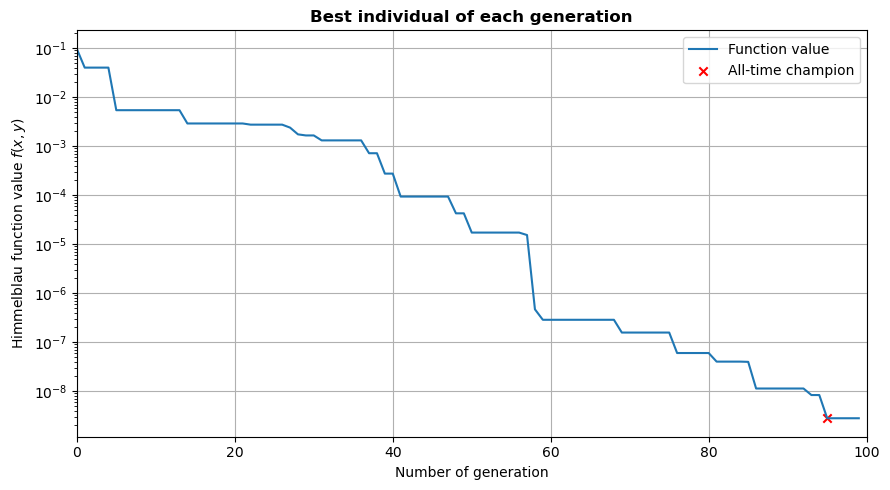

In [7]:
# Extract best individuals for each generation
best_x = [ind[0] for ind in individuals_list]
best_y = [ind[1] for ind in individuals_list]

# Extract problem bounds
(x_min, y_min), (x_max, y_max) = udp.get_bounds()

# Plot fitness over generations
fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(np.arange(0, number_of_evolutions), fitness_list, label='Function value')

# Plot champion
champion_n = np.argmin(np.array(fitness_list))
ax.scatter(champion_n, np.min(fitness_list), marker='x', color='r', label='All-time champion')

# Prettify
ax.set_xlim((0, number_of_evolutions))
ax.grid('major')
ax.set_title('Best individual of each generation', fontweight='bold')
ax.set_xlabel('Number of generation')
ax.set_ylabel(r'Himmelblau function value $f(x,y)$')
ax.legend(loc='upper right')
ax.set_yscale('log')
plt.tight_layout()

# Show the figure
plt.show()

### Himmelblau function
Then, let's plot the Himmelblau function with the best individual of each generation.

This shows that, while solutions were investigated by the optimiser in different places of the design spaces, it did manage to reach the correct one in the end.

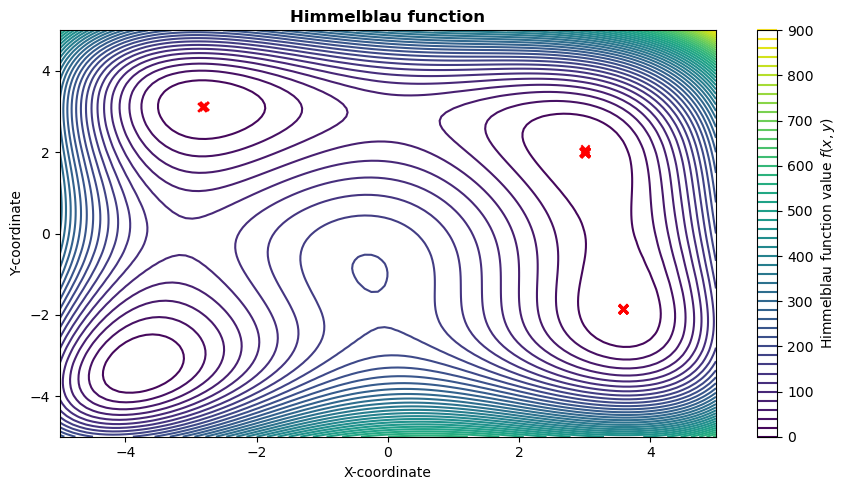

In [8]:
# Plot Himmelblau function
grid_points = 100
x_vector = np.linspace(x_min, x_max, grid_points)
y_vector = np.linspace(y_min, y_max, grid_points)
x_grid, y_grid = np.meshgrid(x_vector, y_vector)
z_grid = np.zeros((grid_points, grid_points))
for i in range(x_grid.shape[1]):
    for j in range(x_grid.shape[0]):
        z_grid[i, j] = udp.fitness([x_grid[i, j], y_grid[i, j]])[0]
        
# Create figure
fig, ax = plt.subplots(figsize=(9,5))
cs = ax.contour(x_grid, y_grid, z_grid, 50)

# Plot best individuals of each generation
ax.scatter(best_x, best_y, marker='x', color='r')

# Prettify
ax.set_xlim((x_min, x_max))
ax.set_ylim((y_min, y_max))
ax.set_title('Himmelblau function', fontweight='bold')
ax.set_xlabel('X-coordinate')
ax.set_ylabel('Y-coordinate')
cbar = fig.colorbar(cs)
cbar.ax.set_ylabel(r'Himmelblau function value $f(x,y)$')
plt.tight_layout()

# Show the plot
plt.show()

### Visualise vicinity of minimum
Let's make the same plot as before, but zooming in on the optimum at (3, 2).

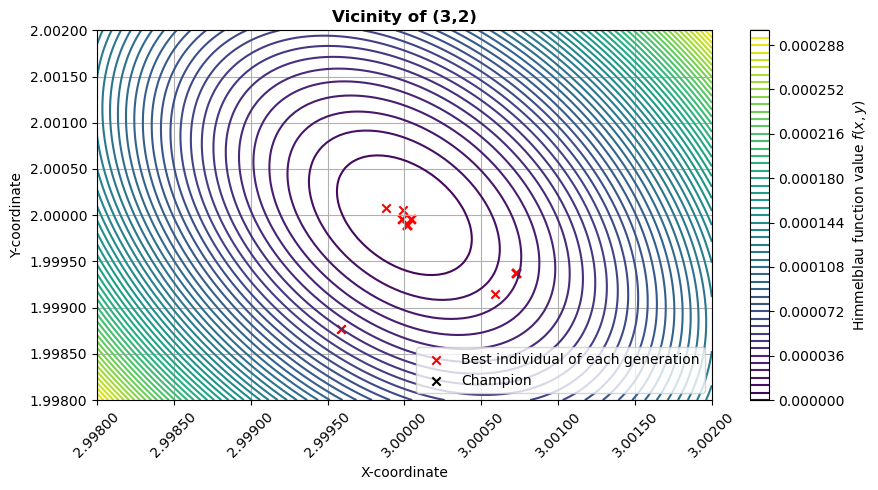

In [9]:
eps = 2E-3
x_min, x_max = (3 - eps, 3 + eps)
y_min, y_max = (2 - eps, 2 + eps)
grid_points = 100
x_vector = np.linspace(x_min, x_max, grid_points)
y_vector = np.linspace(y_min, y_max, grid_points)
x_grid, y_grid = np.meshgrid(x_vector, y_vector)
z_grid = np.zeros((grid_points, grid_points))
for i in range(x_grid.shape[1]):
    for j in range(x_grid.shape[0]):
        z_grid[i, j] = udp.fitness([x_grid[i, j], y_grid[i, j]])[0]
fig, ax = plt.subplots(figsize=(9, 5))
cs = ax.contour(x_grid, y_grid, z_grid, 50)
# Plot best individuals of each generation
ax.scatter(best_x, best_y, marker='x', color='r', label='Best individual of each generation')
ax.scatter(pop.champion_x[0], pop.champion_x[1], marker='x', color='k', label='Champion')
# Prettify
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%1.5f'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%1.5f'))
plt.xticks(rotation=45)
ax.set_xlim((x_min, x_max))
ax.set_ylim((y_min, y_max))
ax.set_title('Vicinity of (3,2)', fontweight='bold')
ax.set_xlabel('X-coordinate')
ax.set_ylabel('Y-coordinate')
cbar = fig.colorbar(cs)
cbar.ax.set_ylabel(r'Himmelblau function value $f(x,y)$')
ax.legend(loc='lower right')
ax.grid('major')
plt.tight_layout()

# Show the figure
plt.show()

## Grid search
To investigate how well the Differential Evolution algorithm performed, let's now run the optimisation with a grid search of 1000x1000 nodes.

This leads to a difference w.r.t. the minimum in the order of $10^{-3}$. This means that the grid search requires about 5 times more function evaluations to reach a minimum with an accuracy 1000 times worse than the Differential Evolution algorithm.

In [10]:
# Set number of points
number_of_nodes = 1000

# Extract problem bounds
(x_min, y_min), (x_max, y_max) = udp.get_bounds()
x_vector = np.linspace(x_min, x_max, number_of_nodes)
y_vector = np.linspace(y_min, y_max, number_of_nodes)
x_grid, y_grid = np.meshgrid(x_vector, y_vector)
z_grid = np.zeros((number_of_nodes, number_of_nodes))
for i in range(x_grid.shape[1]):
    for j in range(x_grid.shape[0]):
        z_grid[i, j] = udp.fitness([x_grid[i, j], y_grid[i, j]])[0]

# Extract the best individual
best_f = np.min(z_grid)
best_ind = np.argmin(z_grid)
best_x_GS = (x_grid.flatten()[best_ind], y_grid.flatten()[best_ind])

print('\n########### RESULTS OF GRID SEARCH (' + str(number_of_nodes) + ' nodes per variable) ########### ')
print('Best fitness with grid search (' + str(number_of_nodes) + ' points):', best_f)
print('Decision variable vector: ', best_x_GS)
print('Number of function evaluations: ', number_of_nodes**2)
print('Difference wrt the minimum: ', best_x_GS - np.array([3, 2]))


########### RESULTS OF GRID SEARCH (1000 nodes per variable) ########### 
Best fitness with grid search (1000 points): 0.0004214702438393723
Decision variable vector:  (2.997997997997998, 1.9969969969969972)
Number of function evaluations:  1000000
Difference wrt the minimum:  [-0.002002 -0.003003]


## Monte Carlo search
Finally, let's perform our optimisation again with a Monte Carlo search, also with 1000x1000 nodes.

This also leads to a difference w.r.t. the minimum in the order of $10^{-3}$. This means that the Monte Carlo search requires about 5 times more function evaluations to reach a minimum with an accuracy 1000 times worse than the Differential Evolution algorithm, much like the grid search.

In [11]:
# Fix seed (for reproducibility)
random.seed(current_seed)

# Size of random number vector
number_of_points = 1000
x_vector = random.random(number_of_points)
x_vector *= (x_max - x_min)
x_vector += x_min
y_vector = random.random(number_of_points)
y_vector *= (y_max - y_min)
y_vector += y_min
x_grid, y_grid = np.meshgrid(x_vector, y_vector)
z_grid = np.zeros((number_of_points, number_of_points))
for i in range(x_grid.shape[1]):
    for j in range(x_grid.shape[0]):
        z_grid[i, j] = udp.fitness([x_grid[i, j], y_grid[i, j]])[0]
        
# Get the best individual
best_f = np.min(z_grid)
best_ind = np.argmin(z_grid)
best_x_MC = (x_grid.flatten()[best_ind], y_grid.flatten()[best_ind])

print('\n########### RESULTS OF MONTE-CARLO SEARCH (' + str(number_of_points) + ' points per variable) ' +
                                                                                '########### ')
print('Best fitness with grid search (' + str(number_of_points) + ' points):', best_f)
print('Decision variable vector: ', best_x_MC)
print('Number of function evaluations: ', number_of_points**2)
print('Difference wrt the minimum: ', best_x_MC - np.array([3, 2]))


########### RESULTS OF MONTE-CARLO SEARCH (1000 points per variable) ########### 
Best fitness with grid search (1000 points): 0.000709478710487308
Decision variable vector:  (3.0045948649555445, 1.9990355170582665)
Number of function evaluations:  1000000
Difference wrt the minimum:  [ 0.00459486 -0.00096448]
